# Introducción

La tienda de videojuegos online **Ice** vende sus producto alrededor del mundo y recopila información de cada una de sus ventas así también, le da seguimiento a cada título (videojuego) y ve su comportamiento para las diferentes plataformas. Así también, se tienen reseñas de **"The Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento)"**.

**Objetivo**: Detectar proyectos prometedores para la planificación de campañas futuras.

**Tabla de contenidos**
- Preparando los datos: En esta sección se hizo el tratamiento para registros duplicados, ausentes y tipo de datos para las diferentes columnas
- Analizando datos: Esta sección contiene el análisis de las plataformas potencialmente prometedoras y sus ventas a lo largo de su periodo de vida
- Perfil de usuario para cada región: Esta sección busco patrones relacionados con las ventas generadas en otras características como son la plataforma de los videojuegos, su género e incluso su clasificación
- Prueba de hipótesis: Esta sección presenta conclusiones sobre hipótesis planteadas entre calificaciones de usuario y plataformas y por otro lado entre calificaciones de usuario y generos de los videojuegos en contraste con las ventas.

In [72]:
# Importanto librerias
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from statistics import median
from scipy.stats import levene
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import csv

In [73]:
# Leyendo archivo csv
df = pd.read_csv('datasets/games.csv')
df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


# Preparando los datos

In [74]:
# Mostrando información de "df"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Observando las primeras filas del dataset, el cual contiene `16715` registros en total, ademas, podemos observar la información que nos proporciona y es la siguiente:

- `Name`: El nombre del videojuego y cuenta con un total de `16713` del total. El tipo de dato es `object` por lo tanto es correcto. El nombre de la columna debe ser cambiado de `Name` a `name`.
- `Platform`: Plataforma para la que esta disponible el videojuego. El tipo de dato es `object` que es correcto y el nombre debe ser cambiado a `platform`.
- `Year_of_Release`: Año de lanzamiento del videojuego cuenta con `16446` del total, debe ser del tipo `int64` y el nombre correcto debe ser `year_of_release`.
- `Genre`: Genero del videojuego que tiene `16713` del total, es del tipo `object` lo cual es correcto sin embago el nombre correcto debe ser `genre`.
- `NA_sales`: Ventas en Norteamérica en millones de dólares estadounidenses, con el nombre `na_sales`.
- `EU_sales`: Ventas en Europa en millones de dólares estadounidenses, con el nombre `eu_sales`.
- `JP_sales`: Ventas en Japón en millones de dólares estadounidenses, con el nombre `jp_sales`.
- `Other_sales`: Ventas en otros países en millones de dólares estadounidenses, con el nombre `other_sales`.
- `Critic_Score`: Puntaje recibido de crítica, es categórica con un máximo de `100` y cuenta con `8137` registros del total, debe ser renombrada por `critic_score`.
- `User_Score`: Puntaje recibido por parte del usuario, es categórica con un máximo de `10` y cuenta con `10014` del total, debe renombrarse por `user_score`.
- `Rating`: Claisifación recibida por **ESRB**, es categórica, cuenta con `9949` registros del total y debe ser renombrada por `rating`.

Como podemos observar las columnas requiere de ajustes como ser renombradas, verificación de aquellos valores ausentes, además de validar que no haya registros duplicados, etc.

Comenzaremos trabajando con el nombre de las columnas para que estas tengan el adecuado.

In [75]:
# Renombrando las columnas de "df"
df.columns = ['name','platform','year_of_release','genre','na_sales',
              'eu_sales','jp_sales','other_sales','critic_score','user_score','classification']
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  classification   9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Como podemos observar los nombres de las columnas ya tiene un formato adecuado que permite trabajar de mejor forma con ellos. Esto da pie a poder verificar que no contemos con registros duplicados.

## Verificando duplicidad de registros

In [76]:
# Verificando duplicidad de registros
df.duplicated().sum()


0

Podemos observar que no contamos con datos duplicados por completo, es decir, que alguna fila coincida en su totalidad con al menos otra fila, sin embago, puede que esto cambie conforme se vaya haciendo el análisis y preparación de los datos.

Comenzaremos a analizar los valores ausentes.

## Trabajando con los valores ausentes y tipos de datos
### Valores ausentes para la columna "name"

In [77]:
# Trabajando con los valores ausentes para la columna "name"
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


De acuerdo con la información obtenida, unicamente tenemos dos registros con valores ausentes en la columna `name` que coincide con valores ausentes en `genre`, `critic_score`, `user_score` y `classification`. También muestran pocas ventas de manera general donde incluso uno de esos registros muestra  ventas unicamente en Japón.

Procederemos a ver si hay alguna relación de la información que se tiene para `platform` igual a `GEN` y `year_of_release` igual a `1993.0` pues son los únicos valores que tenemos en común para estos registros.

In [78]:
# Verificando valores ausentes en "name" a través de un nuevo filtrado
df[(df['platform'] == 'GEN') & (df['year_of_release'] == 1993.0)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
7885,Shining Force II,GEN,1993.0,Strategy,0.00,0.00,0.19,0.00,NaN,NaN,NaN
8893,Super Street Fighter II,GEN,1993.0,Fighting,0.00,0.00,0.15,0.00,NaN,NaN,NaN
11986,Ecco: The Tides of Time,GEN,1993.0,Adventure,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12098,Street Fighter II': Special Champion Edition (...,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12264,Streets of Rage 3,GEN,1993.0,Action,0.00,0.00,0.07,0.00,NaN,NaN,NaN
12984,Dynamite Headdy,GEN,1993.0,Platform,0.00,0.00,0.05,0.00,NaN,NaN,NaN
13343,Beyond Oasis,GEN,1993.0,Role-Playing,0.00,0.00,0.05,0.00,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


De acuerdo con la tabla filtrada, nos podemos dar cuenta que no tenemos algún patrón que pueda ayudarnos, si bien la mayoría coincide que fuerón videojuegos vendidos unicamente en Japón y el restante fue vendido en otras regiones menos en Japón, no tenemos alguna otra guia que oriente al nombre de estos registros. Por tal razón, procederemos a eliminarlos del `df`.

In [79]:
# Eliminando los registros vacios en la columna "name"
df = df[df['name'].isna() != True]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  classification   9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


### Valores ausentes y tipo de dato para la columna "year_of_release"

Comenzaremos trabajando con los valores ausentes de la columna para finalizar cambiando el tipo de dato de la misma, esto es debido a que si tenemos valores ausnetes en la columna, cambiar el tipo de dato no es posible.

In [80]:
# Trabajando con los valores ausentes para la columna "year_of_release"
df[df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


De acuerdo con la tabla filtrada, nos encontramos con `269` registros nulos en esta columna, sin embargo podriamos en primera estancia, podemos observar que en el titulo, se tiene el año de publicación del juego, como ejemplo tenemos a `Madden NFL 2004`. Podemos comenzar extrayendo estos años de los titulos y asignarlos a la columna.

In [81]:
# Rellenando los valores ausentes de "year_of_release" con "0" para mejor manipulación
df['year_of_release'].fillna(0,inplace=True)

In [82]:
# Creando la función de extracción de años contenidos en los titulos
def name_year(row):
    name = row['name']
    year = row['year_of_release']
    
    regex = "[0-9]{4}"
    if year == 0:
        result = re.findall(regex,name)
        if result != []:
            return float(result[0])
        else:
            return 0
    else:
        return year
    
df['year_of_release'] = df.apply(name_year,axis=1)
df[df['year_of_release'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
456,LEGO Batman: The Videogame,Wii,0.0,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
609,Space Invaders,2600,0.0,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,0.0,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,0.0,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
678,LEGO Indiana Jones: The Original Adventures,Wii,0.0,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
...,...,...,...,...,...,...,...,...,...,...,...
16348,Agarest Senki: Re-appearance,PS3,0.0,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16405,Freaky Flyers,GC,0.0,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,0.0,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,0.0,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Como podemos visualizar en la tabla anterior, pudimos extraer `17` años de lanzamiento que venían incluidos en los titulos de los videojuegos dejando un total de `252` datos aun pendientes por evualar si es posible extraer o estimar el año de lanzamiento.

Vamos a ubicar el mismo título para otras plataformas con la intención de detectar el año de aquellos registros que no lo tienen, de haber coincidencias, extraeremos dicha información para vaciarla en el registro correspondiente.

In [83]:
# Funcion para localizar años con el mismo nombre de videojuego para otras plataformas
df_auxiliar = df[df['year_of_release'] != 0]
def search_years(row):
    name = row['name']
    year = row['year_of_release']
    
    if year == 0:
        result = list(df_auxiliar[df_auxiliar['name'] == name]['year_of_release'])
        if len(result) != 0:
            return int(median(result))
        else:
            return 0
    else:
        return year
        
df['year_of_release'] = df.apply(search_years,axis=1)
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [84]:
# Comprobando información de "df"
df[df['year_of_release'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
627,Rock Band,X360,0.0,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,0.0,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
805,Rock Band,Wii,0.0,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T
1142,Rock Band,PS3,0.0,Misc,0.99,0.41,0.00,0.22,92.0,8.4,T
1301,Triple Play 99,PS,0.0,Sports,0.81,0.55,0.00,0.10,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16277,Homeworld Remastered Collection,PC,0.0,Strategy,0.00,0.01,0.00,0.00,86.0,8.2,E10+
16288,Shorts,DS,0.0,Platform,0.01,0.00,0.00,0.00,NaN,tbd,E10+
16348,Agarest Senki: Re-appearance,PS3,0.0,Role-Playing,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16458,Hakuouki: Shinsengumi Kitan,PS3,0.0,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Como podemos observar, pudierón ser recuperados otros registros que si bien no contaban con un año en la columna `year_of_release`, para otras plataformas, el mismo título de videojuego si lo tenía. Cabe aclarar que el mismo título pudo haber sido publicado para varias plataformas, por ende, para no obtener un valor que estuviera fuera de los posibles, se trabajo con la `mediana` para posteriormente se convertida a número entero.

Procederemos con ver cuantos de los títulos faltantes hay para las diferentes plataformas. Hasta este punto tenemos `139` registros faltanes de los `16713`, es decir, menos del `1%` del total de datos; si no se encuentra algún patrón, podemos considerar la opción de eliminar dichos registros.

In [85]:
# Agrupando la cantidad de lanzamientos de los títulos faltantes para cada plataforma
df[df['year_of_release'] == 0].pivot_table(index='name',values='platform',aggfunc='count')

,platform
name,
Action Man-Operation Extreme,1
Advance Wars: Days of Ruin,1
Adventure,1
Agarest Senki: Re-appearance,1
Air-Sea Battle,1
...,...
Yoostar on MTV,1
Yu Yu Hakusho: Dark Tournament,1
Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),1


Como podemos observar de los `139` registros faltantes tenemos `127` títulos distintos, por lo que no tenemos algún patrón en estos videojuegos restantes del que podamos determinar el año de lanzamiento, por otro lado, la cantidad de títulos faltantes sería muy complicado de consultar de forma manual.

Por estas razones, procederemos con la eliminación de estos registros para poder continuar con el preprocesamiento de los datos.

In [86]:
# Eliminando registros restantes
idx = list(df[df['year_of_release'] != 0]['name'].index)
df = df.loc[idx,:]

In [87]:
# Comprobando cambios realizados
df[df['year_of_release'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification


In [88]:
# Información de "df"
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16574 non-null  object 
 1   platform         16574 non-null  object 
 2   year_of_release  16574 non-null  float64
 3   genre            16574 non-null  object 
 4   na_sales         16574 non-null  float64
 5   eu_sales         16574 non-null  float64
 6   jp_sales         16574 non-null  float64
 7   other_sales      16574 non-null  float64
 8   critic_score     8079 non-null   float64
 9   user_score       9938 non-null   object 
 10  classification   9871 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


### Valores ausentes y tipo de dato para la columna "critic_score" (leer nota)

<div class="alert alert-block alert-info">
<b>**PRECAUCIÓN**</b>

Esta sección hace uso de un "web scraper" esta funcionalidad se propuso como solución a la cantidad de valores ausentes que estan presentes en las columnas "critic_score", "user_score" y "classification", sin embargo en recuperar dicha información toma alrededor de **2 horas** terminar de realizar las solicitudes. Como propuesta alternativa, se proporcionara el archivo "CSV" generado al final de este proceso para disminuir el tiempo de ejecución, todo esto se deja a consideración del revisor, de igual manera quedo pendiente de su respuesta y comentarios.
    
    
<b>Liga del archivo: https://drive.google.com/file/d/192acafHxQrPGoJlyoCWMAVN5pDYX-gLJ/view?usp=share_link</b>   
    <a class="tocSkip"></a>
</div>

In [89]:
# Trabajando con los valores ausentes de la columna "critic_score"
df[df['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Como podemos observar de acuerdo a los datos filtrados, poco más de la mitad de los registros que se tienen estan ausentes en la columna `critic_score`. Procederemos a evaluar si a traves de los títulos de los videojuegos podemos determinar los valores para esta columna.

In [90]:
# Obteniendo información de los títulos para la columna "critic_score"
df_auxiliar = df[df['critic_score'].isna() == False].pivot_table(index='name',values='critic_score')
df_auxiliar

,critic_score
name,
Tales of Xillia 2,71.0
.hack//Infection Part 1,75.0
.hack//Mutation Part 2,76.0
.hack//Outbreak Part 3,70.0
007 Racing,51.0
...,...
inFAMOUS: Second Son,80.0
nail'd,65.0
pro evolution soccer 2011,77.4


De acuerdo con este resultado, tenemos alrededor de `3400` títulos duplicados que si cuenta con un valor en la columna `critic_score`, por tal motivo, crearemos una función que busque estos titulos y a través del calculo de la mediana y en caso de ser posible, sustituya los valores nulos por el `critic_score` encontrado.

In [91]:
# Generando la función "search_critic_scores"
df['critic_score'].fillna(0,inplace=True)
df_auxiliar = df[df['critic_score'].isna() == False]
def search_critic_scores(row):
    name = row['name']
    score = row['critic_score']
    
    if score == 0:
        result = list(df_auxiliar[df_auxiliar['name'] == name]['critic_score'])
        if len(result) != 0:
            return int(median(result))
        else:
            return 0
    else:
        return score
    
df['critic_score'] = df.apply(search_critic_scores,axis=1)
df[df['critic_score'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,0.0,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,0.0,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN


Aun tenemos un total de `7801` registros que tienen vacia la información para la columna `critic_score` lo cual sigue siendo una cantidad realmente representativa de los datos de la tabla `df`, por tal motivo, procederemos con otro tipo de análisis para poder completar dicha información.

De acuerdo con la tabla, podemos observar que hay registros que tienen ventas por debajo de los `10,000` dolares en ventas en cualquier de las regiones. Al tener ventas por esa cantidad significa que no fuerón títulos prometedores para los usuarios y por ende su popularidad no fue buena. De acuerdo con lo anterior, buscaremos cuál es la diferencia en ventas de entre todas las regiones.

In [92]:
# Encontrando ventas por regiones
print("Para Norteamérica la venta máxima fue de",max(df['na_sales']),"y la mínima fue",min(df['na_sales']))
print("Para Europa la venta máxima fue de",max(df['eu_sales']),"y la mínima fue",min(df['eu_sales']))
print("Para Japón la venta máxima fue de",max(df['jp_sales']),"y la mínima fue",min(df['jp_sales']))
print("Para otras regiones la venta máxima fue de",max(df['other_sales']),"y la mínima fue",min(df['other_sales']))

Para Norteamérica la venta máxima fue de 41.36 y la mínima fue 0.0
Para Europa la venta máxima fue de 28.96 y la mínima fue 0.0
Para Japón la venta máxima fue de 10.22 y la mínima fue 0.0
Para otras regiones la venta máxima fue de 10.57 y la mínima fue 0.0


Podemos observar de acuerdo a los resultados una constante, en tadas las regiones, el valor mínimo es de `0.0` en ventas, sin embargo esto puede ser válido porque puede que existan títulos que no salierón a la venta en determinadas regiones. Por otro lado es importante asegurarnos de que los títulos tengan ventas en al menos una región de las 4 concentradas en este `df`.

In [93]:
# Buscando títulos con ventas de "0.0" en todas las regiones
df[(df['na_sales'] == 0.0) & (df['eu_sales'] == 0.0) & (df['jp_sales'] == 0.0) & (df['other_sales'] == 0.0)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
16676,G1 Jockey 4 2008,PS3,2008.0,Sports,0.0,0.0,0.0,0.0,0.0,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Podemos identificar el caso de dos títulos con esta característica que son:
- `G1 Jockey 4 2008` para la plataforma `PS3`.
- `SCORE International Baja 1000: The Official Game` para la plataforma `PS2`.

Los registros con este tipo de características serán descartados del análisis pues no aportan información alguna para posibles campañas posteriores.

In [94]:
# Eliminado títulos con ventas "0.0" en todas las regiones
df = df[(df['name'] != 'G1 Jockey 4 2008') & (df['name'] != 'SCORE International Baja 1000: The Official Game')]
df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN


In [95]:
# Verificando información del nuevo "df"
df[df['critic_score'] == 0]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,0.0,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,0.0,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN


Podemos observar que un total de `7796` registros de los `16569` aun tienen vacio el campo de `critic_score`, es decir, aproximadamente un `47%` del total.

Investigando en internet, nos encontramos con la página web `gamespot` que es una página que proporciona información sobre el ranking de los videojuegos en los rangos con los que estan trabajando nuestros datos. Por tal mótivo, se implementara un `web scraper` con la intención de poder recuperar todos los datos posibles para las distintas plataformas de los distintos títulos de videojuegos, sin embargo, para esto, se deben preparar los datos de tal forma que puedan ser procesados a través de este `web scraper`.

Los nombres de los videojuegos requiere cierta estructura que es la siguiente:

**https://www.gamespot.com/games/(Nombre del videojuego separado por "-")/**

Por tal motivo, es importante que los títulos de los videojuegos tengan el nombre correcto.

In [25]:
# Creando el objeto que contenga los títulos de los videojuegos
signs = ["'",".",":","(",")","[","]","&"]
accents = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","ä":"a","ë":"e","ï":"i","ö":"o","ü":"u"}
names = []
for i in list(df[df['critic_score'] == 0.0]['name']):
    res = i.lower()
    
    for j in signs:
        res = res.replace(j,"")
        
    for j in accents:
        res = res.replace(j,accents[j])
        
    res = res.replace(" ","-")
    names.append(res)

In [26]:
# Resultado de "names" y longitud
print(names,len(names))

['super-mario-bros', 'pokemon-red/pokemon-blue', 'tetris', 'duck-hunt', 'nintendogs', 'pokemon-gold/pokemon-silver', 'super-mario-world', 'pokemon-diamond/pokemon-pearl', 'super-mario-land', 'super-mario-bros-3', 'pokemon-ruby/pokemon-sapphire', 'pokemon-black/pokemon-white', 'pokemon-yellow-special-pikachu-edition', 'call-of-duty-black-ops-3', 'pokemon-x/pokemon-y', 'super-mario-64', 'pokemon-heartgold/pokemon-soulsilver', 'pokemon-omega-ruby/pokemon-alpha-sapphire', 'super-mario-land-2-6-golden-coins', 'super-mario-all-stars', 'pokemon-firered/pokemon-leafgreen', 'super-mario-64', 'mario-kart-64', 'donkey-kong-country', 'minecraft', 'super-mario-kart', 'goldeneye-007', 'pokemon-black-2/pokemon-white-2', 'mario--sonic-at-the-olympic-games', 'star-wars-battlefront-2015', 'pac-man', 'the-legend-of-zelda-ocarina-of-time', 'crash-bandicoot-2-cortex-strikes-back', 'super-smash-bros-for-wii-u-and-3ds', 'super-mario-bros-2', 'call-of-duty-black-ops-3', 'pokemon-sun/moon', 'mario-kart-double-

In [29]:
# Implementando web scrapper para obtener información faltante de la página "gamespot" para"critic_score"
headers = headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}

critic = []
regex = "[0-9]{2}"

for title in names:
    url = 'https://www.gamespot.com/games/{}/'.format(str(title))
    try:
        response = requests.get(url,headers=headers)
        soup = BeautifulSoup(response.text, "html.parser")

        critic_score = soup.find("div",class_="reviewObject__wrapper")
        critic_score = critic_score.find("dl",class_="reviewObject__metacritic")
        critic_score = critic_score.find("dd")
        critic_score = critic_score.find("a")
        result = re.findall(regex,str(critic_score))

        if len(result) != 0:
            critic.append(float(result[0]))
        else:
            critic.append(0)
    except:
        
        critic.append(0)


In [30]:
# Observando los valores de "critic" para ser ajustados en la columna "critic_score"
print(critic,len(critic))

[84.0, 0, 0, 0, 0, 0, 92.0, 0, 0, 0, 0, 0, 0, 0, 0, 64.0, 0, 82.0, 0, 25.0, 0, 64.0, 64.0, 78.0, 36.0, 0, 64.0, 0, 0, 0, 36.0, 64.0, 0, 0, 0, 0, 0, 0, 0, 36.0, 0, 84.0, 0, 0, 83.0, 0, 64.0, 92.0, 0, 66.0, 0, 64.0, 36.0, 71.0, 0, 0, 80.0, 0, 91.0, 0, 84.0, 0, 0, 59.0, 64.0, 0, 0, 66.0, 0, 0, 0, 0, 73.0, 64.0, 36.0, 0, 15.0, 0, 0, 66.0, 36.0, 91.0, 0, 0, 0, 64.0, 0, 0, 0, 0, 0, 87.0, 0, 0, 0, 0, 0, 0, 0, 64.0, 0, 0, 0, 76.0, 0, 64.0, 0, 0, 0, 0, 0, 79.0, 0, 0, 64.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73.0, 0, 0, 70.0, 86.0, 0, 55.0, 84.0, 0, 0, 20.0, 0, 64.0, 15.0, 91.0, 90.0, 0, 0, 0, 0, 64.0, 0, 0, 78.0, 0, 0, 0, 0, 0, 0, 0, 84.0, 0, 36.0, 0, 0, 64.0, 58.0, 64.0, 0, 0, 0, 0, 79.0, 0, 0, 0, 0, 60.0, 0, 0, 0, 63.0, 0, 0, 0, 0, 83.0, 0, 0, 0, 36.0, 0, 74.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 64.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 36.0, 0, 0, 0, 0, 78.0, 0, 0, 0, 0, 0, 0, 20.0, 0, 0, 0, 0, 0, 92.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 86.0, 76.0, 0, 0, 0, 0, 0, 0, 0, 0, 36.0, 0, 0, 0, 0, 0, 0, 0, 72.0, 36.

Como podemos observar, muchos de los valores buscados de acuerdo con el `título` del videojuego no cuentan con una calificación o su calificación es de `0`, esto es debido a que:

- El título no fue encontrado en la página de acuerdo al nombre asignado.
- El título fue encontrado pero este no cuenta con alguna calificación es específico.

Respecto a aquellos títulos que fuerón contrados por título sin embargo no tienen alguna reseña, esto puede deberse a que:

- Pueden ser títulos demo, en los que son juegos que son meramente de prueba.
- Por el año esta evaluación no se pudo haber realizado para el caso de los títulos más viejos.

Si bien pudimos encontrar algunas calificaciones, aun son bastantes las que quedan sin un valor por asignar, por esta razón, de momento seguiremos trabajando con lo obtenido de la web para posteriormente analizar el siguiente paso respecto con estos registros.

In [96]:
# Analizando la información obtenida
print("Cantidad de datos encontrados de la web:",len([i for i in critic if i!=0]))
print("Cantidad de datos no encontrados:", len([i for i in critic if i==0]))

Cantidad de datos encontrados de la web: 690
Cantidad de datos no encontrados: 7106


En concreto de los `7796` datos, pudimos recabar `690` unicaménte, esto quiere decir que aproximadamente el `9%` de los registros nulos en la columna `critic_score` fuerón recuperados quedando pendientes un total de `7106`.

Continuamos con la concatenación ordenada en el `df` original para la columna `cricit_score`.

In [97]:
# Añadiendo los valores encontrados en la web a la columna "critic_score"
critic_score = list(df['critic_score'])
counter = 0
for idx in range(len(critic_score)):
    if critic_score[idx] == 0:
        critic_score[idx] = int(critic[counter])
        counter += 1
        
critic_score = pd.Series(critic_score)
print(critic_score,len(critic_score))
        

0        76.0
1        84.0
2        82.0
3        80.0
4         0.0
         ... 
16564     0.0
16565     0.0
16566    78.0
16567     0.0
16568     0.0
Length: 16569, dtype: float64 16569


Para poder asignar los datos a las columnas, es importante primero resetear los indices del `df` original, esto es debido a que la empatación de los datos se da a través de los indices.

In [98]:
# Resetando indices del "df" original
df.reset_index(inplace=True)
df

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
0,0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,NaN,NaN
2,2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16565,16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,NaN,NaN
16566,16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN


In [99]:
# Asignando la serie "critic_score" a la columna "critic_score" del "df" original
df['critic_score'] = critic_score
df[df['critic_score'] == 0.0]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,NaN,NaN
5,5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,0.0,NaN,NaN
9,9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,0.0,NaN,NaN
10,10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,NaN,NaN
12,12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,9.00,6.18,7.20,0.71,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16563,16708,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,NaN,NaN
16565,16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,NaN,NaN
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,NaN,NaN


Como podemos observar de acuerdo con la tabla resultante, la cantidad de registros coincide en su totalidad con los registros de los que no se pudo obtener información de la web.
De momento continuaremos analizando lo que sucede con la siguiente columna para poder hacer una mejor toma de decisión respecto a los valores ausentes.

### Valores ausentes y tipo de dato para la columna "user_score" (leer nota)

Comenzaremos con el análisis de esta columna para poder determinar que es lo que se debe aplicar para poder trabajar con los valores ausentes.

In [100]:
# Verificando la información
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569 entries, 0 to 16568
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16569 non-null  int64  
 1   name             16569 non-null  object 
 2   platform         16569 non-null  object 
 3   year_of_release  16569 non-null  float64
 4   genre            16569 non-null  object 
 5   na_sales         16569 non-null  float64
 6   eu_sales         16569 non-null  float64
 7   jp_sales         16569 non-null  float64
 8   other_sales      16569 non-null  float64
 9   critic_score     16569 non-null  float64
 10  user_score       9938 non-null   object 
 11  classification   9871 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


De los `16569` registros tenemos un total de `6631` registros nulos, lo cuál nos indica que aproximadamente el `40%` de los datos no se encuentran en la tabla, siendo esto, una cantidad significativa de datos. Por lo anterior, procederemos a ejecutar la misma dinámica que para `critic_score`, a través de un `web scraper` obtendremos la información faltante de la misma página web.

Con la intención de facilitar el trabajo, validaremos la cantidad de `0` que se encuentren en la columna `user_score`, en caso de no haber coincidencias, procederemos con la converción de nulos a `0`.

In [101]:
# Validando columna "user_score"
df[df['user_score'] == 0]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification


Con toda confianza procederemos a asignar `0` a aquellos registros nulos.

In [102]:
# Asignando "0" a los registros nulos en la columna "user_score"
df['user_score'].fillna(0,inplace=True)
df[df['user_score'] == 0]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
1,1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,84.0,0,NaN
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,NaN
5,5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,0.0,0,NaN
9,9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,0.0,0,NaN
10,10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0,NaN
16565,16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,0,NaN
16566,16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0,NaN
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0,NaN


In [40]:
# Creando el objeto que contenga los títulos de los videojuegos
signs = ["'",".",":","(",")","[","]","&"]
accents = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","ä":"a","ë":"e","ï":"i","ö":"o","ü":"u"}
names = []
for i in list(df[df['user_score'] == 0]['name']):
    res = i.lower()
    
    for j in signs:
        res = res.replace(j,"")
        
    for j in accents:
        res = res.replace(j,accents[j])
        
    res = res.replace(" ","-")
    names.append(res)

In [52]:
# Implementando web scrapper para obtener información faltante de la página "gamespot" para user_score"
headers = headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}

user = []
regex = "[0-9]{1}.[0-9]{1}"

for title in names:
    url = 'https://www.gamespot.com/games/{}/'.format(str(title))
    try:
        response = requests.get(url,headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        user_score = soup.find("div",class_="reviewObject__wrapper")
        user_score = user_score.find("dl",class_="reviewObject__userAvg")
        user_score = user_score.find("dd")
        
        result = re.findall(regex,str(user_score))

        if len(result) != 0:
            user.append(float(result[0]))
        else:
            user.append(0)
    
    except:  
        user.append(0)


In [53]:
# Observando los valores de "user" para ser ajustados en la columna "user_score"
print(user,len(user))

[8.9, 0, 8.7, 8.3, 0, 0, 9.3, 0, 8.1, 9.3, 0, 0, 0, 0, 0, 0, 0, 8.4, 0, 9.2, 0, 0, 8.5, 8.8, 8.6, 8.9, 7.0, 0, 0, 0, 7.4, 9.6, 8.6, 0, 8.1, 0, 0, 0, 0, 0, 8.8, 8.8, 0, 8.7, 8.7, 8.8, 9.3, 7.3, 0, 7.9, 8.8, 8.6, 8.1, 7.9, 9.3, 8.4, 8.9, 0, 6.7, 0, 8.9, 210.0, 8.6, 8.3, 7.9, 0, 0, 0, 0, 0, 9.3, 0, 0, 0, 7.8, 8.3, 9.6, 8.6, 7.8, 8.8, 0, 7.3, 0, 7.1, 0, 0, 8.6, 0, 8.8, 7.1, 7.6, 0, 0, 0, 8.8, 0, 0, 0, 0, 8.5, 7.7, 0, 0, 9.1, 7.7, 0, 0, 0, 7.8, 0, 5.9, 0, 0, 0, 0, 8.8, 8.5, 6.5, 7.4, 0, 6.9, 0, 0, 0, 0, 0, 7.6, 7.0, 0, 6.5, 7.4, 0, 8.4, 8.1, 8.4, 0, 7.3, 7.9, 0, 0, 200.0, 8.5, 8.3, 0, 0, 8.7, 200.0, 0, 8.2, 7.3, 0, 6.5, 6.5, 0, 8.4, 0, 0, 0, 8.2, 0, 0, 8.6, 5.8, 7.9, 0, 8.2, 8.1, 0, 7.9, 7.8, 7.8, 7.9, 8.3, 0, 0, 0, 8.1, 0, 7.8, 0, 198.0, 0, 8.3, 0, 7.7, 8.6, 8.7, 8.3, 0, 8.1, 8.4, 0, 8.2, 7.7, 0, 0, 0, 0, 8.3, 0, 8.7, 8.6, 7.3, 9.5, 6.8, 0, 0, 0, 0, 7.1, 0, 0, 0, 0, 7.1, 0, 8.8, 0, 7.9, 8.8, 0, 0, 0, 0, 8.2, 5.4, 200.0, 8.1, 9.3, 0, 0, 7.1, 8.6, 0, 0, 0, 0, 0, 0, 0, 0, 5.6, 0, 8.3, 6.2, 0,

In [104]:
# Añadiendo los valores encontrados en la web a la columna "user_score"
user_score = list(df['user_score'])
counter = 0
for idx in range(len(user_score)):
    if user_score[idx] == 0:
        user_score[idx] = float(user[counter])
        counter += 1
        
user_score = pd.Series(user_score)
print(user_score,len(user_score))

0            8
1          8.9
2          8.3
3            8
4          0.0
         ...  
16564      0.0
16565    200.0
16566      0.0
16567      0.0
16568      0.0
Length: 16569, dtype: object 16569


In [105]:
# Asignando la serie "user_score" a la columna "user_score" del "df" original
df['user_score'] = user_score
df[df['user_score'] == 0.0]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,NaN
10,10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,0.0,NaN
12,12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,9.00,6.18,7.20,0.71,0.0,0.0,NaN
20,20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,0.0,0.0,NaN
25,25,Pokemon Ruby/Pokemon Sapphire,GBA,2002.0,Role-Playing,6.06,3.90,5.38,0.50,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16562,16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,0.0,0.0,NaN
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,NaN
16566,16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,NaN
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,NaN


De acuerdo con la tabla resultante, de los `6631` registros faltantes, `2406` fuerón recuperados de la web a través del `web scraper`. De igual forma, estos valores ausentes quedarán pendientes para el final de la sección con la intención de tomar la mejor decisión para su manejo.

### Valores ausentes y tipo de dato para la columna "classification" (leer nota)

Para la última columna, tendremos la misma dinámica que con `critic_score` y `user_score` pues los resultados han sido favorables en el sentido de recuperar la mayor información posible.

In [106]:
# Validando información para la columna "classification"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569 entries, 0 to 16568
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16569 non-null  int64  
 1   name             16569 non-null  object 
 2   platform         16569 non-null  object 
 3   year_of_release  16569 non-null  float64
 4   genre            16569 non-null  object 
 5   na_sales         16569 non-null  float64
 6   eu_sales         16569 non-null  float64
 7   jp_sales         16569 non-null  float64
 8   other_sales      16569 non-null  float64
 9   critic_score     16569 non-null  float64
 10  user_score       16569 non-null  object 
 11  classification   9871 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB


Podemos observar que tenemos `6648` registros aun faltantes y a través del `web scraper` podemos recuperar dicha información. Para poder trabajar esta columna, el tipo de dato que tiene es `object` por tal motivo, verificaremos si esta columna cuanta con un guión medio como valor asignado en alguno de los registros, de no ser así usaremos este símbolo para poder trabajar de manera adecuada la columna.

In [107]:
# Verificando información de la columna "classification"
df[df['classification'] == "-"]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification


In [108]:
# Asignando guión medio como valor momentaneo a la columna "classification"
df['classification'].fillna("-",inplace=True)
df[df['classification'] == "-"]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
1,1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,84.0,8.9,-
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,-
5,5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,0.0,8.7,-
9,9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,0.0,8.3,-
10,10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-
16565,16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,200.0,-
16566,16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,-
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,-


Para poder ejecutar el `web scraper` es importante extraer los títulos de aquellos videojuegos que tienen valores nulos para esta columna para posteriormente ejecutarlo y de nueva cuenta, extraer dichos datos de la página web anteriormente consultada.

In [60]:
# Creando el objeto que contenga los títulos de los videojuegos
signs = ["'",".",":","(",")","[","]","&"]
accents = {"á":"a","é":"e","í":"i","ó":"o","ú":"u","ä":"a","ë":"e","ï":"i","ö":"o","ü":"u"}
names = []
for i in list(df[df['classification'] == "-"]['name']):
    res = i.lower()
    
    for j in signs:
        res = res.replace(j,"")
        
    for j in accents:
        res = res.replace(j,accents[j])
        
    res = res.replace(" ","-")
    names.append(res)

In [63]:
# Implementando web scrapper para obtener información faltante de la página "gamespot" para "classification"
headers = headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}

cls = []
regex = '(?:Everyone 10)|(?:Everyone)|(?:Teen)|(?:Mature)|(?:Kids to Adults)|(?:Rating Pending)'

for title in names:
    url = 'https://www.gamespot.com/games/{}/'.format(str(title))
    try:
        response = requests.get(url,headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")

        classification = soup.find("div",class_="pod-object-stats__esrb flexbox-row")
        classification = classification.find("dt",class_="vertical-spacing-small-bottom-rem")

        result = re.findall(regex,str(classification))

        if len(result) != 0:
            cls.append(result[0])
        else:
            cls.append(0)
    
    except: 
        
        cls.append(0)
        

In [64]:
print(cls,len(cls))

['Everyone', 0, 'Everyone', 'Everyone', 0, 0, 0, 0, 'Everyone', 'Everyone', 0, 0, 0, 0, 0, 'Kids to Adults', 0, 'Everyone', 'Everyone', 'Kids to Adults', 0, 'Kids to Adults', 'Kids to Adults', 'Kids to Adults', 'Everyone 10', 'Everyone', 'Teen', 0, 0, 0, 'Everyone', 'Everyone 10', 'Kids to Adults', 0, 'Everyone', 0, 0, 0, 'Kids to Adults', 0, 'Everyone', 'Everyone', 0, 'Everyone', 'Everyone', 'Everyone', 'Everyone', 'Everyone', 'Everyone', 'Everyone', 'Everyone', 'Everyone 10', 'Everyone', 'Everyone', 'Everyone', 'Kids to Adults', 'Kids to Adults', 'Everyone', 0, 'Everyone', 'Teen', 'Everyone', 'Everyone', 'Kids to Adults', 0, 0, 'Everyone', 'Mature', 0, 'Everyone', 0, 0, 0, 'Everyone', 'Everyone', 'Everyone 10', 'Everyone 10', 'Everyone', 'Teen', 0, 'Everyone', 'Everyone', 'Everyone', 'Kids to Adults', 0, 'Teen', 0, 'Kids to Adults', 'Everyone', 'Kids to Adults', 0, 0, 0, 'Everyone', 0, 0, 0, 0, 'Mature', 'Everyone', 0, 0, 'Everyone', 'Everyone', 0, 0, 'Kids to Adults', 'Teen', 0, 'Ev

Por otro lado, los valores extraidos de la página web, tienen un formato distinto, por tal motivo, se construirá un objeto que permita ajustar los valores a los que contiene la columna `classification`.

In [111]:
# Extrayendo los valores unicos de la columna "classification"
df['classification'].unique()

array(['E', '-', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [112]:
# Creando el objeto para la columna "classification"
class_obj = {"Everyone":"E", 
             "Everyone 10":"E10+", 
             "Teen":"T", 
             "Mature":"M", 
             "Kids to Adults":"K-A",
             "Rating Pending":"-",
             0:"-"}


In [114]:
len(cls)

6648

Una vez teniendo el objeto con el que vamos a trabajar los valores, procedemos a convertir los valores de la lista `cls` en los valores correctos para el `dataframe`.

In [118]:
# Ajustando los valores obtenidos de la web para la columna "classification"
classif = list(df['classification'])
counter = 0
for idx in range(len(classif)):
    if classif[idx] == "-":
        classif[idx] = class_obj[cls[counter]]
        counter += 1
        
classification = pd.Series(classif)
print(classification,len(classification))

0        E
1        E
2        E
3        E
4        E
        ..
16564    -
16565    -
16566    -
16567    -
16568    -
Length: 16569, dtype: object 16569


Con toda información y con motivos de simplificar el trabajo posterior reduciendo la cantidad de tiempo de ejecución se propone la construcción de un nuevo archivo `CSV` para almacenar la información resultante del `web scraper` y continuar con el resto del proyecto.

Primero las columnas nuevas deben ser conjuntadas con el `df` original, por tal mótivo, este será modificado con los nuevos valores.

In [119]:
# Consolidando registros para la columna "classification"
df['classification'] = classification
df[df['classification'] == "-"]


,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
10,10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,0.0,-
20,20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,0.0,0.0,-
25,25,Pokemon Ruby/Pokemon Sapphire,GBA,2002.0,Role-Playing,6.06,3.90,5.38,0.50,0.0,0.0,-
27,27,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,5.51,3.17,5.65,0.80,0.0,0.0,-
30,30,Pokémon Yellow: Special Pikachu Edition,GB,1998.0,Role-Playing,5.89,5.04,3.12,0.59,0.0,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-
16565,16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,200.0,-
16566,16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,-
16567,16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,-


De acuerdo con la tabla resultante, de los `6648` registros nulos en la columna `classification` pudimos recuperar con éxito `2632`, que de igual manera, al haber una gran cantidad de registros faltantes, estos debén ser trabajados de una manera distinta. De momento, procederemos con el almacenamiento de un nuevo archivo `CSV` con la intención de agilizar la siguiente sección.

In [120]:
# Almacenando archivo de manera local
df.to_csv("datasets/games_v2.csv",header=True)

In [121]:
# Leyendo nuevo "df"
new_df = pd.read_csv("datasets/games_v2.csv")
new_df.drop(['Unnamed: 0','index'],axis=1,inplace=True)
new_df = new_df.drop(new_df[new_df['genre'] == 0].index)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569 entries, 0 to 16568
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16569 non-null  object 
 1   platform         16569 non-null  object 
 2   year_of_release  16569 non-null  float64
 3   genre            16569 non-null  object 
 4   na_sales         16569 non-null  float64
 5   eu_sales         16569 non-null  float64
 6   jp_sales         16569 non-null  float64
 7   other_sales      16569 non-null  float64
 8   critic_score     16569 non-null  float64
 9   user_score       16569 non-null  object 
 10  classification   16569 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [122]:
# Visualizando resultados del "new_df"
new_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,84.0,8.9,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,E
...,...,...,...,...,...,...,...,...,...,...,...
16564,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-
16565,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,200.0,-
16566,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,-
16567,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,-


### Valores ausentes y tipo de dato para las columnas "critic_score", "user_score" y "classification" despues de haber realizado el web scraping

Una vez que creamos el nuevo documento, procederemos con el análisis final sobre los datos ausentes en las tres columnas trabajadas anteriormente. Comenzaremos identificando aquellos registros de los que no se pudo obtener mayor información.

In [131]:
# Convirtiendo la columna "user_score" a tipo de dato "float"
new_df.loc[new_df['user_score'] == 'tbd',['user_score']] = -1
new_df = new_df.astype({'user_score':'float64'})
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16569 entries, 0 to 16568
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16569 non-null  object 
 1   platform         16569 non-null  object 
 2   year_of_release  16569 non-null  float64
 3   genre            16569 non-null  object 
 4   na_sales         16569 non-null  float64
 5   eu_sales         16569 non-null  float64
 6   jp_sales         16569 non-null  float64
 7   other_sales      16569 non-null  float64
 8   critic_score     16569 non-null  float64
 9   user_score       16569 non-null  float64
 10  classification   16569 non-null  object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [132]:
# Verificando datos de "new_df"
new_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,84.0,8.9,E
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,E


In [133]:
# Registros que no pudierón ser encontradas en la web
new_df[(new_df['critic_score'] == 0.0) & (new_df['user_score'] == 0.0) & (new_df['classification'] == '-')]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,0.0,0.0,-
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,0.0,0.0,-
25,Pokemon Ruby/Pokemon Sapphire,GBA,2002.0,Role-Playing,6.06,3.90,5.38,0.50,0.0,0.0,-
27,Pokemon Black/Pokemon White,DS,2010.0,Role-Playing,5.51,3.17,5.65,0.80,0.0,0.0,-
30,Pokémon Yellow: Special Pikachu Edition,GB,1998.0,Role-Playing,5.89,5.04,3.12,0.59,0.0,0.0,-
...,...,...,...,...,...,...,...,...,...,...,...
16556,Eiyuu Densetsu: Sora no Kiseki Material Collec...,PSP,2007.0,Role-Playing,0.00,0.00,0.01,0.00,0.0,0.0,-
16562,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,0.0,0.0,-
16564,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-
16567,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,-


Como podemos observar en la tabla resultante del filtro, hay registros que no pudierón ser extraidos de la web y las razones pueden ser las siguientes:

- Los títulos de los videojuegos no pudierón ser encontrados porque no se encontraban en la página web.
- Los títulos no pudierón ser encontrados porque el nombre no es el correcto.
- Los títulos no pudierón ser encontrados por un mal parseo de la forma adopatada para viajar entre páginas web.
- Los títulos si fuerón encontrados pero estos no fuerón evaluados aun por especialistas y/o usuarios.
- La `ESRB` fue creada en `1994`,  por tal motivo puden existir títulos anteriores a esta fecha que no fuerón clasificados o cualquier de los casos anteriormente mencionados.

Por tales motivos, y considerando que estos registros son alrededor del `16%` de la muestra, estos registros pueden ser excluidos de análisis futuros pues si bien no cuentan con alguna calificación, si generarón ingresos incluso siendo algunos muy elevados.

Por otro lado, es importante conocer las ventas totales de los videjuegos con la intención de conocer las ventas a nivel mundial que han tenido puesto que si bien, no son tan prometedoras en algunas regiones, puede que en otras si, por tal mótivo, procederemos con crear la columna total_sales que contendra la suma total de las columnas na_sales, eu_sales, jp_sales y other_sales.

In [134]:
# Creando la columna "total_sales"
new_df['total_sales'] = new_df['na_sales'] + new_df['eu_sales'] + new_df['jp_sales'] + new_df['other_sales']
new_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,84.0,8.9,E,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,E,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-,0.01
16565,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,200.0,-,0.01
16566,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,-,0.01
16567,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,0.0,0.0,-,0.01


# Analizando los datos

En esta sección comenzaremos con el análisis de los datos con la intención de descubrir tendencias y patrones de los datos desde diferentes perspectivas.

## Gráfica de videojuegos lanzados por año

Comenzaremos graficando la cantidad de videojuegos lanzados por año, con la intención de visualizar en que años fuerón lanzados al mercado más titulos independientemente de la `plataforma` para la que fuerón diseñados.

<AxesSubplot:ylabel='Frequency'>

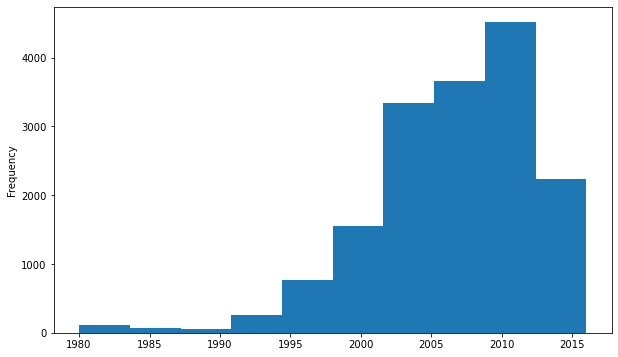

In [135]:
# Graficando cantidad de videojuegos por año
new_df['year_of_release'].plot(kind='hist',figsize=(10,6))

Como podemos ver, entre el año `2002` y el `2013` se tuvo la mayor cantidad de titulos lanzados al mercado. Esto puede deberse a la diversidad de `plataformas` existentes en ese tiempo pues posiblemente se pusierón a la venta mayor cantidad tanto de estación como portatiles y por ende se publicarón mayor cantidad de títulos tanto disponibles para diferentes `plataformas` como títulos exclusivos.

## Ventas por plataforma

Continuaremos analizando las ventas generadas totales por plataforma de las que se tiene registro en este `df`.

<AxesSubplot:title={'center':'Ingresos generados por plataforma'}, xlabel='platform', ylabel='millones de dolares'>

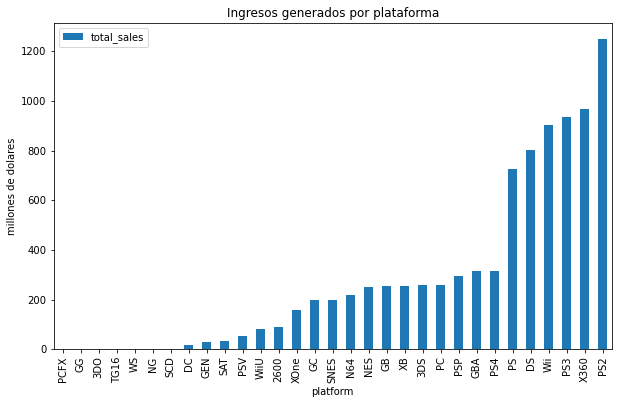

In [136]:
# Graficando ventas totales por plataforma
new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=True).plot(kind='bar',figsize=(10,6),
                                                                                                                         title='Ingresos generados por plataforma',ylabel='millones de dolares')


In [137]:
# Ingresos generados de las plataformas
new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)


,total_sales
platform,
PS2,1250.92
X360,966.54
PS3,935.11
Wii,903.21
DS,804.28
PS,727.58
PS4,314.14
GBA,313.73
PSP,293.57


Para poder determinar que plataformas han sido las más prometedoras a lo largo de estos años, calcularemos el `promedio` y `mediana` de ventas anuales que han tenido y partiremos de ese dato.

In [138]:
# Promedio y mediana anual en ventas
print(new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').mean())
print(new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').median())

total_sales    286.233548
dtype: float64
total_sales    200.04
dtype: float64


Consideraremos el `promedio` como nuestra medida de referencia para indicar que una plataforma fue considerada o no exitosa, es decir, aquellas con ingresos generados superiores a los `286.23 millones de dolares` totales, serán consideradas para el análsis posterior.

De acuerdo con la sumatoría, aquellas plataformas con más ventas anuales son, en orden ascendente, `PS2`, `X360`, `PS3`, `Wii`, `DS`, `PS`, `PS4`, `GBA`, `PSP`, sin embargo recordemos que estas ventas son las totales del perido completo que estamos analizando. Por tal motivo, es importante que conozcamos más a detalle estas plataformas analizando las ventas por año que han generado.

## Ventas anuales de las plataformas con mayores ingresos totales
### Ventas anuales de la plataforma "Play Station 2"

Comenzaremos analizando las ventas anuales de la plataforma `PS2` para ver el comportamiento que ha tenido desde el año de lanzamiento hasta la actualidad.

In [139]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'PS2'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2000.0,39.17
2001.0,166.43
2002.0,207.14
2003.0,185.93
2004.0,221.50
2005.0,161.23
2006.0,107.03
2007.0,76.10
2008.0,53.90


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "Play Station 2"'}, xlabel='year_of_release', ylabel='millones de dolares'>

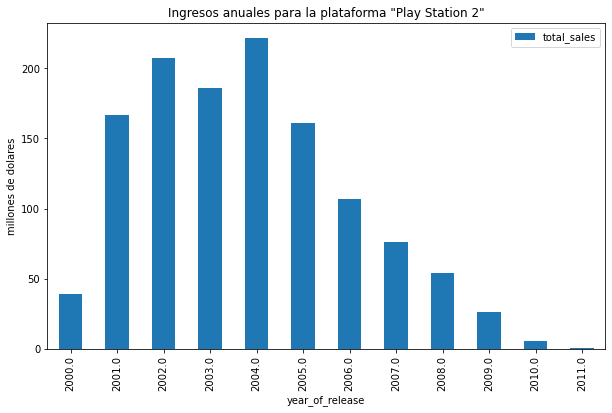

In [140]:
# Analizando comportamiento de la plataforma "GameBoy" a través del tiempo
new_df[new_df['platform'] == 'PS2'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "Play Station 2"',
                                                                                                                ylabel='millones de dolares')


El resultado obtenido de las ventas para esta plataforma es muy variado puesto que para el año de su lanzamiento, `(2000)` sus ventas fuerón muy bajas en comparación con el siguiente año `2001` con un total de `166.43 millones de dolares` en ventas, para el año `2002` nuevamente superó sus ventas con `207.14 millones de dolares`. Para el año `2004` alcanzo su pico de ventas con un total de `221.5 millones de dolares` en ventas, posicionandose como la plataforma con más ingresos registrados en la historía.

### Ventas anuales de la plataforma "Xbox 360"

In [141]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'X360'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2005.0,9.22
2006.0,51.79
2007.0,95.42
2008.0,135.94
2009.0,120.82
2010.0,170.55
2011.0,145.28
2012.0,100.72
2013.0,88.58


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "X360"'}, xlabel='year_of_release', ylabel='millones de dolares'>

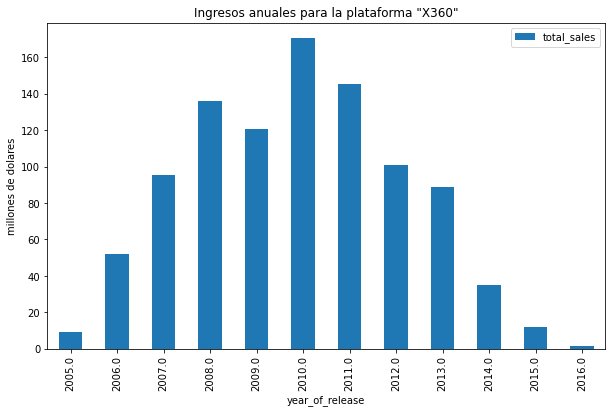

In [142]:
# Analizando comportamiento de la plataforma "PS4" a través del tiempo
new_df[new_df['platform'] == 'X360'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "X360"',
                                                                                                                ylabel='millones de dolares')


Algo a destacar de esta gráfica es que tenemos un comportamiento de campana, es decir, inicio su ventas bajas llegando a su pico aproximadamente a la mitad de su periodo de vida y mostrando un baja considerable en ventas al día de hoy. Su pico de ventas se dió en el año `2010` con un total de `170.55 millones de dolares` en ventas.

### Ventas anuales de la plataforma "Play Station 3"

In [143]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'PS3'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2005.0,0.19
2006.0,21.44
2007.0,73.19
2008.0,118.71
2009.0,130.93
2010.0,142.96
2011.0,157.98
2012.0,108.28
2013.0,113.25


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "PS3"'}, xlabel='year_of_release', ylabel='millones de dolares'>

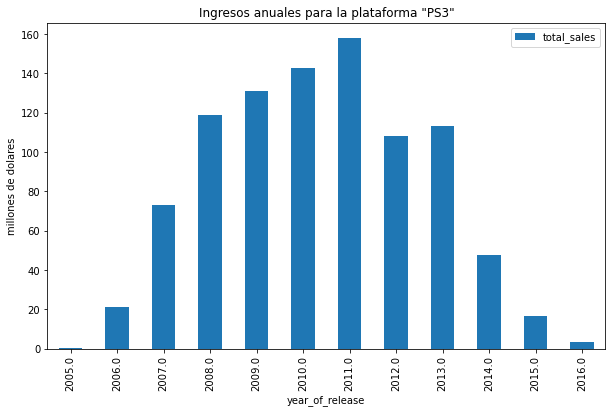

In [144]:
# Analizando comportamiento de la plataforma "PS" a través del tiempo
new_df[new_df['platform'] == 'PS3'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "PS3"',
                                                                                                                ylabel='millones de dolares')


La gráfica tiene una forma de campana nuevamente, es dcir, nuevamente un comportamiento en decadencia al día de hoy, logrando un ingreso pico en el año `2011` con un total de ventas de `157.98 millones de dolares`, sin eembargo y aparentemente, es una plataforma que ya va de salida del mercado.

### Ventas anuales de la plataforma "Nintendo Wii"

In [145]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'Wii'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2006.0,140.19
2007.0,153.41
2008.0,177.58
2009.0,206.97
2010.0,128.67
2011.0,59.79
2012.0,22.94
2013.0,8.59
2014.0,3.75


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "Wii"'}, xlabel='year_of_release', ylabel='millones de dolares'>

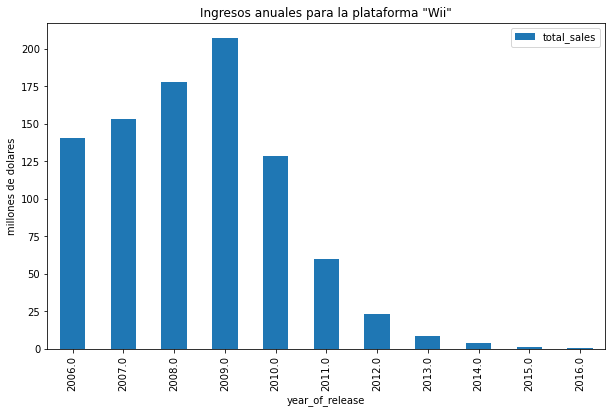

In [146]:
# Analizando comportamiento de la plataforma "Wii" a través del tiempo
new_df[new_df['platform'] == 'Wii'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "Wii"',
                                                                                                                ylabel='millones de dolares')


A diferencia de las plataformas anteriormente graficadas, esta plataforma empezo con ventas superiores, llegando a su pico en el año `2009` con un total de `206.97 millones de dolares` en ventas en las distintas regiones. Posteriormente se nota un decrecimiento en las ventas hasta la acutalidad donde, aparentemente, puede pasar a ser una plataforma sustituida por otra.

### Ventas anuales de la plataforma "DS"

In [147]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'DS'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
1985.0,0.02
2004.0,17.27
2005.0,130.14
2006.0,119.81
2007.0,147.23
2008.0,145.36
2009.0,119.56
2010.0,85.35
2011.0,26.33


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "Nintendo DS"'}, xlabel='year_of_release', ylabel='millones de dolares'>

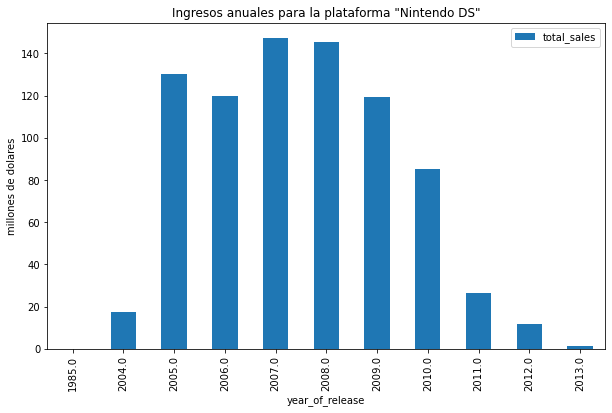

In [148]:
# Analizando comportamiento de la plataforma "DS" a través del tiempo
new_df[new_df['platform'] == 'DS'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "Nintendo DS"',
                                                                                                                ylabel='millones de dolares')


Algo a resaltar de esta gráfica es que podemos observar que comienza en el año `1985` lo cuál es incongruente pues de acuerdo con `Wikipedia` el `Nintendo DS` se comenzo a vender en el año `2004`, por tal motivo, procederemos a revisar este/estos registros.

In [149]:
# Analizando el año "1985" para la plataforma "DS"
new_df[(new_df['platform'] == "DS") & (new_df['year_of_release'] == 1985.0)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification,total_sales
15821,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.0,0.0,0.02,0.0,0.0,0.0,-,0.02


Al tratarse de un solo registro, este puede ser investigado de forma manula y de acuerdo con la página web consultada para el `web scraping` hay muchos títulos similares sin embargo no hay alguno que concuerde con este, por tal motivo, será eliminado este título de `new_df` con la intención de evitar rengos erroneos.

In [150]:
# Elimiando "Strongest Tokyo University Shogi DS" de "new_df"
new_df = new_df[new_df['name'] != "Strongest Tokyo University Shogi DS"]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16568 entries, 0 to 16568
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16568 non-null  object 
 1   platform         16568 non-null  object 
 2   year_of_release  16568 non-null  float64
 3   genre            16568 non-null  object 
 4   na_sales         16568 non-null  float64
 5   eu_sales         16568 non-null  float64
 6   jp_sales         16568 non-null  float64
 7   other_sales      16568 non-null  float64
 8   critic_score     16568 non-null  float64
 9   user_score       16568 non-null  float64
 10  classification   16568 non-null  object 
 11  total_sales      16568 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.6+ MB


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "Nintendo DS"'}, xlabel='year_of_release', ylabel='millones de dolares'>

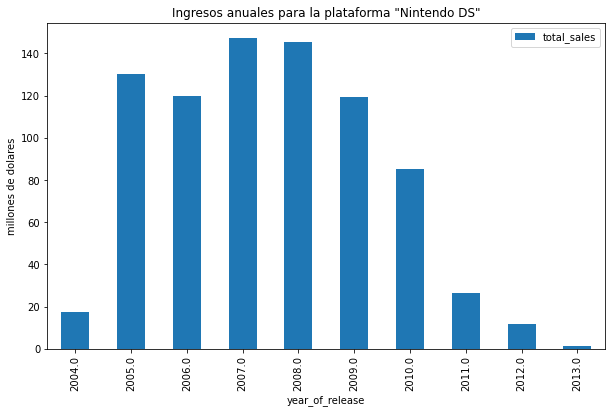

In [151]:
# Analizando comportamiento de la plataforma "DS" a través del tiempo
new_df[new_df['platform'] == 'DS'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "Nintendo DS"',
                                                                                                                ylabel='millones de dolares')


Una vez, eliminado el título que nos provoca información erronea, podemos observar en la nueva gráfica que tiene forma de campana, un comportamiento aparenteme habitual en las plataformas de videojuegos. Para esta plataforma su pico en ventas fue en el año `2007` con un total de `147.23 millones de dolares` en ventas, llegando a su fin en el año `2013` con un total de `1.54 millones de dolares`.

### Ventas anuales de la plataforma "Play Station"

In [152]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'PS'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
1994.0,6.03
1995.0,35.96
1996.0,94.70
1997.0,136.17
1998.0,169.49
1999.0,144.53
2000.0,96.37
2001.0,35.59
2002.0,6.67


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "PS"'}, xlabel='year_of_release', ylabel='millones de dolares'>

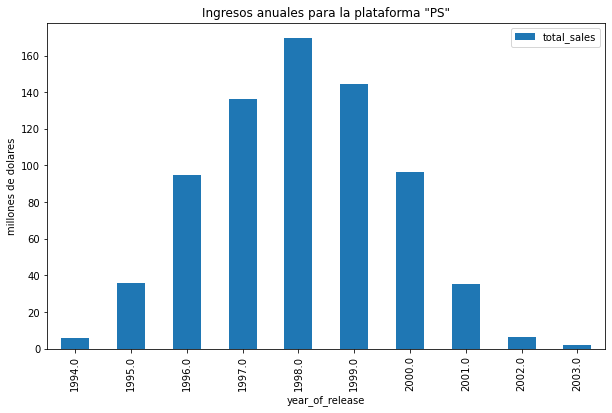

In [153]:
# Analizando comportamiento de la plataforma "PS2" a través del tiempo
new_df[new_df['platform'] == 'PS'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "PS"',
                                                                                                                ylabel='millones de dolares')


Se observa que el pico de ventas fue en `1998` con un total de `169.49 millones de dolares` en ventas llegando a si final en el año `2003` con un total de `2.07 millones de dolares`.

### Ventas anuales de la plataforma "Play Station 4"

In [154]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'PS4'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2013.0,25.99
2014.0,100.00
2015.0,118.90
2016.0,69.25


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "PS4"'}, xlabel='year_of_release', ylabel='millones de dolares'>

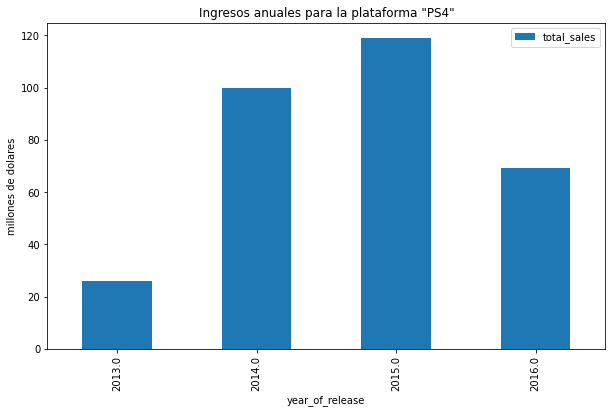

In [155]:
# Analizando comportamiento de la plataforma "XBox 360" a través del tiempo
new_df[new_df['platform'] == 'PS4'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "PS4"',
                                                                                                                ylabel='millones de dolares')


De entrada podriamos decir que la plataforma `PS4` es una plataforma prometedora pues aunque lleva poco tiempo en el mercado (4 años) se ha logrado posicionar entre las primeras 10 con mejores plataformas con mejores ventas. Esta plataforma tuvo su pico de ventas en el año `2015` con un total de `118.90 millones de dolares` en ventas.

### Ventas anuales de la plataforma "GameBoy Advance"

In [156]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'GBA'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2000.0,0.07
2001.0,61.53
2002.0,74.16
2003.0,56.67
2004.0,77.91
2005.0,34.53
2006.0,5.46
2007.0,3.40


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "GBA"'}, xlabel='year_of_release', ylabel='millones de dolares'>

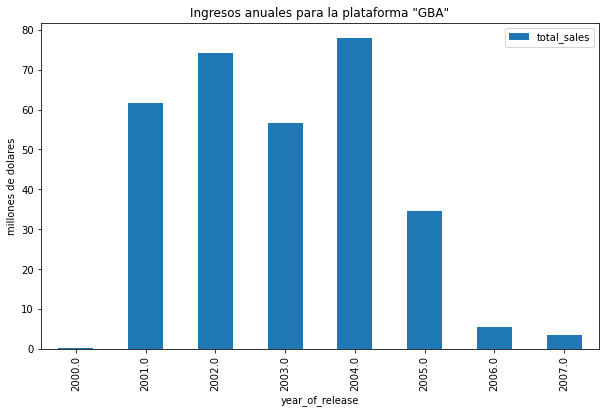

In [157]:
# Analizando comportamiento de la plataforma "XBox 360" a través del tiempo
new_df[new_df['platform'] == 'GBA'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "GBA"',
                                                                                                                ylabel='millones de dolares')


Esta plataforma tuvo un ascenso como se esperaba de acuerdo al comportamiento de las plataformas anteriormente analizadas, para el año `2003` tuvo un decremento considerable, sin embargo, para el siguiente año logró su pico de ventas con un total de `77.91 millones de dolares` en ventas para posteriormente, en el año `2007` llegar a finalizar su periodo de vida.

### Ventas anuales de la plataforma "Play Station Portatil"

In [158]:
# Obteniendo la cantidad de ingresos generados anuales
new_df[new_df['platform'] == 'PSP'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum')

,total_sales
year_of_release,
2004.0,7.06
2005.0,43.84
2006.0,56.28
2007.0,47.30
2008.0,35.96
2009.0,38.58
2010.0,35.04
2011.0,17.82
2012.0,7.95


<AxesSubplot:title={'center':'Ingresos anuales para la plataforma "PSP"'}, xlabel='year_of_release', ylabel='millones de dolares'>

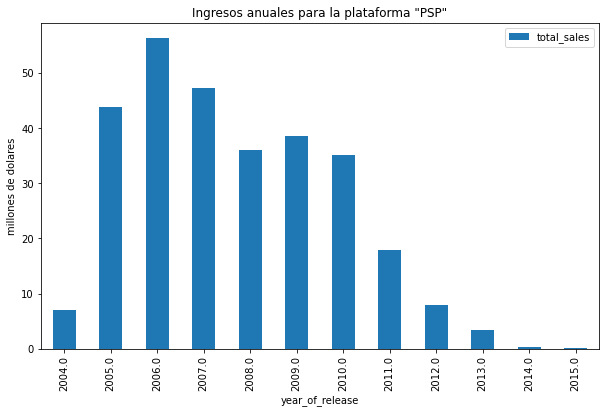

In [159]:
# Analizando comportamiento de la plataforma "XBox 360" a través del tiempo
new_df[new_df['platform'] == 'PSP'].pivot_table(index='year_of_release',values='total_sales',aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                                                                title='Ingresos anuales para la plataforma "PSP"',
                                                                                                                ylabel='millones de dolares')


Esta plataforma es la última de esta sección y podemos observar que su pico de ventas fue en el `2006` con un total de `56.28 millones de dolares` en ventas. Tuvo un periodo de vida relativamente largo de aproximadamente `11 año` llegando a su fin en el `2015`.

In [ ]:
# Mostrando periodo de vida de las plataformas más populares
platforms = ['PS3','X360','PS2','Wii','DS','PS','PS4','GB']
for platform in platforms:
    print('El rango de vida de "{}" fue desde "{}" hasta "{}".'.format(platform,
                                                                       min(new_df[new_df['platform'] == platform]['year_of_release']),
                                                                       max(new_df[new_df['platform'] == platform]['year_of_release'])))


Como podemos observar de entre las plataformas más populares en este `df`, algunas de ellas ya no generan ventas hoy en día, siendo el caso de `Play Station 2`, `Nintendo DS`, `Play Station`, `GameBoy Advance` y concluyendo con `Play Station Portatil`.

Aproximadamente el perido de vida de las plataformas anteriormente mencionadas es de `9 años` lo que duran en el mercado generando ingresos. Un caso que podemos resaltar es para las nuevas plataformas integradas al mercado como lo son `PS3` y `PS4`, que si bien `PS3` es una plataforma que aun se mantiene en la actualidad, también es cierto que ya va de salida en el mercado comenzando a ser sustituida por el `PS4` con una diferencia de `7 años` en sus lanzamiento pues `PS3` fue lanzada al mercado en `2006` mientras que `PS4` fue lanzada en el `2013`.

**Conclusión de sección:** Podemos afirmar que la duración de las plataformas en el mercado es de aproximadamente `9 años` siendo sustituidas por las plataformas de nuevas generaciones aproximadamente cada `7 años`. Sin embargo si bien algunas de las plataformas generarón ventas muy buenas a lo largo de su periodo de vida, la intención es ajustar los datos para campañas para el próximo año, por tal motivo es importante trabajar con plataformas que aun el día de hoy generan ingresos.

In [160]:
# Consultando registros para consolas que aun estan vigentes
all_plaforms = list(new_df['platform'].unique())
platforms = []
for platform in all_plaforms:
    if max(new_df[new_df['platform'] == platform]['year_of_release']) == 2016.0:
        platforms.append(platform)

print(platforms)

['Wii', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'WiiU', 'PSV']


In [161]:
# Filtrando "new_df" para plataformas vigentes en la actualidad
new_df = new_df[new_df['platform'].isin(platforms)]
new_df


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
...,...,...,...,...,...,...,...,...,...,...,...,...
16562,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.00,0.0,0.0,-,0.01
16564,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,0.0,0.0,-,0.01
16565,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,0.0,200.0,-,0.01
16566,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,78.0,0.0,-,0.01


Al obtener aquellos registros con las plataformas vigentes en la actualidad, nos queda un `df` con un total de `6569` registros. Para la siguiente sección analizaremos las plataformas potenciales y su comportamiento a lo largo de los años.

## Ventas anuales de las plataformas vigentes

Analizaremos cual es el orden respecto a ventas totales de las distintas plataformas.

In [162]:
# Ordenamiento de las plataformas de menor a mayor
new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=True)


,total_sales
platform,
PSV,53.81
WiiU,82.19
XOne,159.32
3DS,258.53
PC,258.86
PS4,314.14
Wii,903.21
PS3,935.11
X360,966.54


### Analizando el comportamiento de las ventas a lo largo del tiempo para las plataformas vigentes

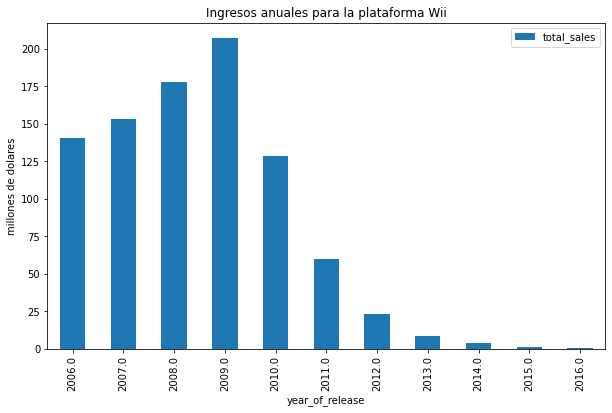

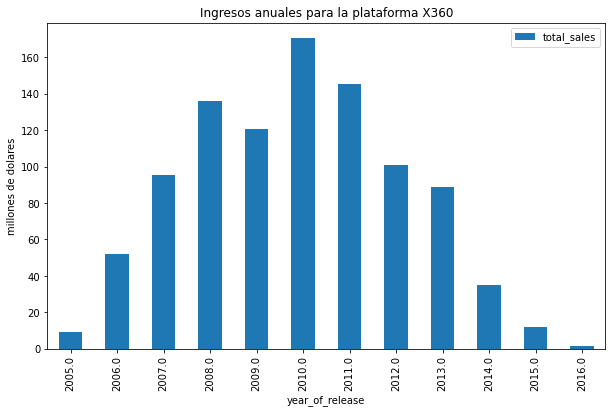

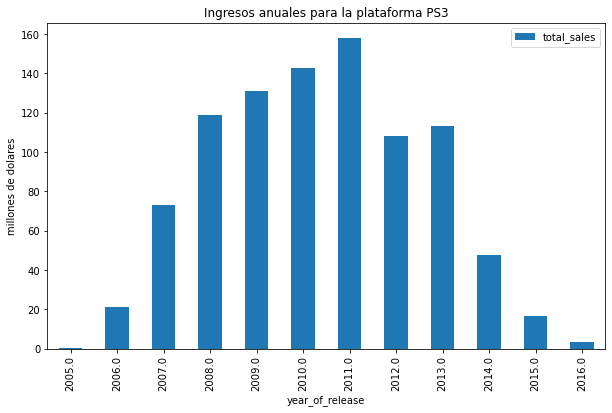

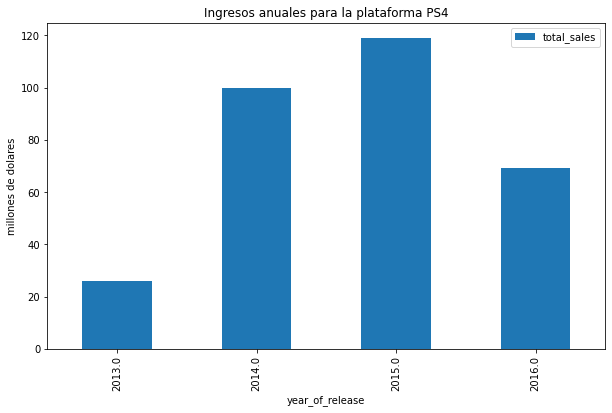

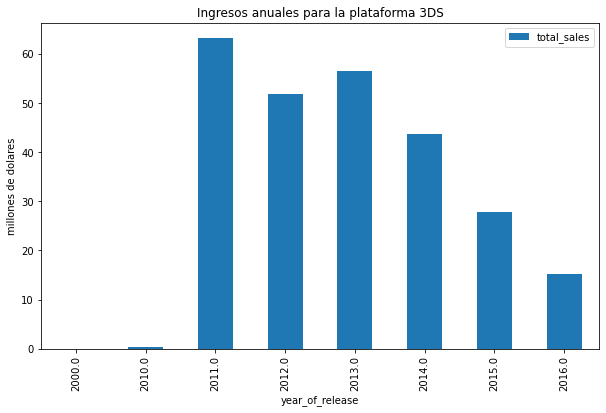

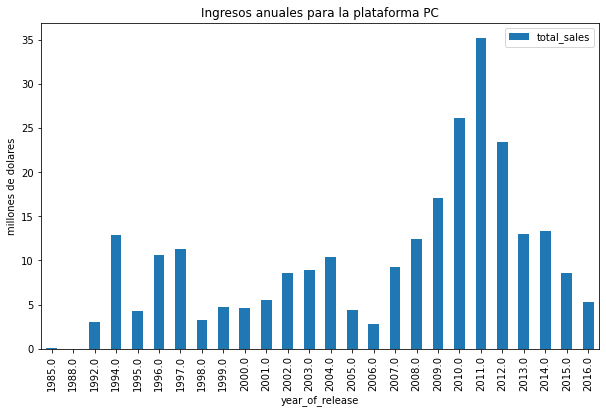

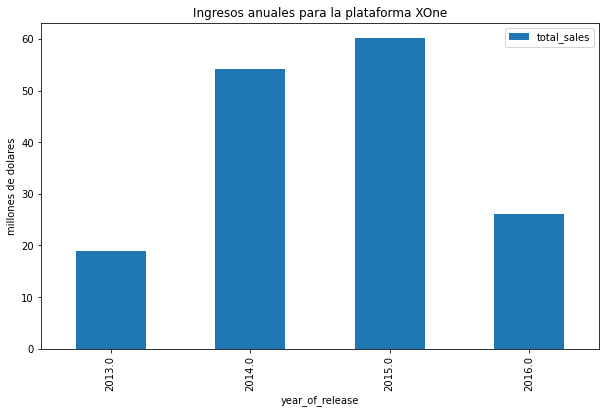

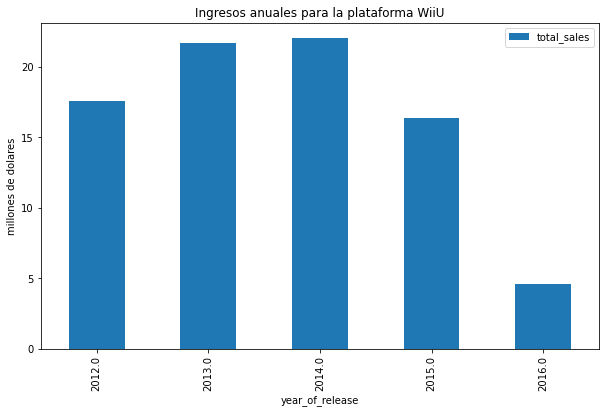

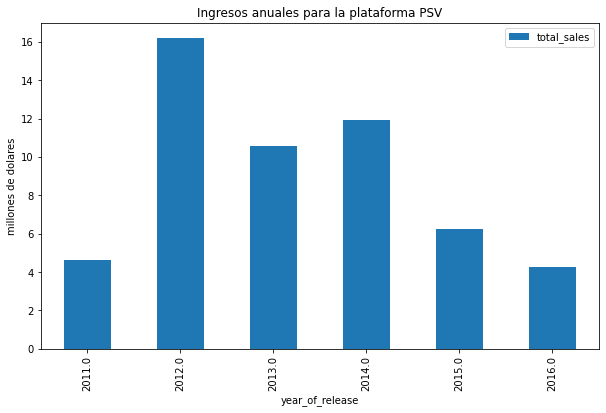

In [163]:
# Graficando el comportamiento de las plataformas vigentes
for platform in platforms:
    new_df[new_df['platform'] == platform].pivot_table(index='year_of_release',
                                                       values='total_sales',
                                                       aggfunc='sum').plot(kind='bar',figsize=(10,6),
                                                                           title=f'Ingresos anuales para la plataforma {platform}',
                                                                           ylabel='millones de dolares')

    

In [164]:
# Obteniendo ingresos anuales
for platform in platforms:
    print(f'Plataforma {platform}')
    print(new_df[new_df['platform'] == platform].pivot_table(index='year_of_release',
                                                       values='total_sales',
                                                       aggfunc='sum'))

Plataforma Wii
                 total_sales
year_of_release             
2006.0                140.19
2007.0                153.41
2008.0                177.58
2009.0                206.97
2010.0                128.67
2011.0                 59.79
2012.0                 22.94
2013.0                  8.59
2014.0                  3.75
2015.0                  1.14
2016.0                  0.18
Plataforma X360
                 total_sales
year_of_release             
2005.0                  9.22
2006.0                 51.79
2007.0                 95.42
2008.0                135.94
2009.0                120.82
2010.0                170.55
2011.0                145.28
2012.0                100.72
2013.0                 88.58
2014.0                 34.74
2015.0                 11.96
2016.0                  1.52
Plataforma PS3
                 total_sales
year_of_release             
2005.0                  0.19
2006.0                 21.44
2007.0                 73.19
2008.0                118.

De acuerdo con las gráficas y de manera general, todas las plataformas estan sufriendo un decremento en las ventas para el año `2016`, sin embargo, aquellas que se encuentran en riesgo de poder salir de mercado son:

- Wii con un ingreso de `0.18 millones de dolares`.
- Xbox 360 con un ingreso de `1.52 millones de dolares`.
- Play Station 3 con un ingreso de `3.6 millones de dolares`.

Con las plataformas restantes aun generan ingresos por encima de los `4 millones de dolares` representando esto un diferencia considerable con las presentadas anteriormente y de acuerdo con lo encontrado en la sección anterior es la tendencia de aquellas plataformas que salen del mercado.

Por tal motivo, las plataformas más rentables que seran con las que continuaremos este análisis son:

- Play Station 4
- Nintendo 3DS
- PC
- Xbox One
- Wii U
- Play Station Vita

## Ventas anuales de los diferentes títulos de videojuegos

Procederemos con el análisis de los títulos de los videojuegos presentando diagramas de caja en contraste con las ventas totales registradas y la plataforma asociada.

total_sales    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

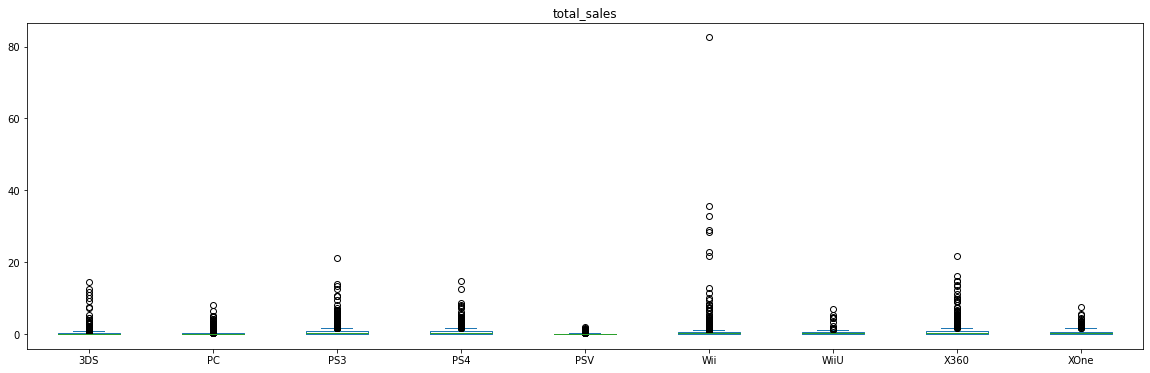

In [165]:
# Generando diagrama de caja 
new_df.plot.box(column='total_sales',by='platform',figsize=(20,6))

Gracias al diagrama de caja, podemos obtener información de las ventas totales por título para las distintas plataformas de nuestro `df` y es la siguiente:

- Podemos observar una diferencia significativa en ventas entre las distintas plataformas, resaltando y por mucho, títulos para la plataforma `Wii` seguida de `Xbox 360` y terminando con `Play Station 3`.
- Las ventas registradas para la plataforma `Play Station Vita` se concentran en un rago reducido a diferencia del resto de las plataformas.
- Para la plataforma `Wii` hay ventas de títulos muy superiores al promedio incluso a tener títulos con ventas superiores a los `80 millones de dolares`.
- A diferencia de la plataforma `Play Station Vita` el promedio de ventas de los títulos se encuentra cercano al `25%` del diagrama de caja lo que nos lleva a pensar que hay una gran cantidad de títulos que no sobresalen de un rango de ventas reducido y este va aproximadamente de los `100 mil dolares` y hasta aproximadamente los `3 millones de dolares`.
- En todas las plataformas podemos observar que hay títulos con ventas muy por encima del promedio y que de manera teórica, podrían considerase como ventas atípicas, por lo que valdría la pena analizar las reseñas y puntajes de críticas para estos títulos.

## Analizando la relación de las ventas con las reseñas de los títulos

Para este análisis, nos centraremos en una sola plataforma que será, `Wii` esto con el motivo que es el que presenta la mayor cantidad de valores atípicos en ventas para los distintos títulos.

In [166]:
# Analizando los datos para la plataforma "Wii"
new_df[new_df['platform'] == "Wii"]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,classification,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
...,...,...,...,...,...,...,...,...,...,...,...,...
16445,Bomberman,Wii,2008.0,Puzzle,0.00,0.00,0.01,0.00,36.0,8.1,-,0.01
16482,The Ultimate Battle of the Sexes,Wii,2010.0,Misc,0.01,0.00,0.00,0.00,0.0,-1.0,T,0.01
16520,Mahou Sensei Negima!? Neo-Pactio Fight!!,Wii,2007.0,Fighting,0.00,0.00,0.01,0.00,0.0,0.0,-,0.01
16540,Help Wanted: 50 Wacky Jobs (jp sales),Wii,2008.0,Simulation,0.00,0.00,0.01,0.00,0.0,0.0,-,0.01


Como podemos observar, para esta plataforma contamos con un total de `1300` registros del total que contiene los títulos para las plataformas vigentes. Procederemos a presentar un diagrama de disperción para visualizar con un poco más de detalle la distribución de los ingresos de los títulos disponibles para esta plataforma y sus reseñas por parte de los profesionales.

<AxesSubplot:xlabel='total_sales', ylabel='critic_score'>

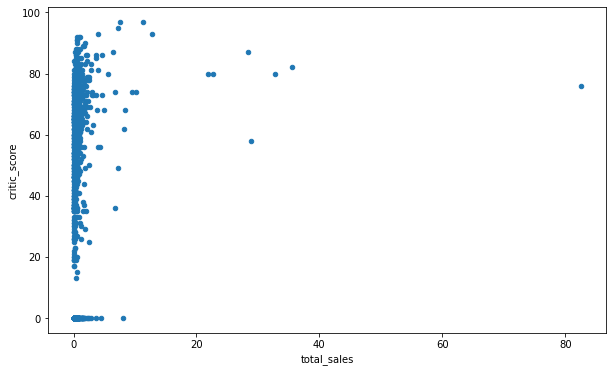

In [167]:
# Creado diagrama de disperción para el total de ventas y la columna "critic_score"
new_df[new_df['platform'] == "Wii"].plot.scatter(x='total_sales',y="critic_score",figsize=(10,6))

Podemos obsevar algunos detalles en este gráfico de disperción y son los siguientes:
- Tenemos títulos que presentan ventas y que aun no han sido calificados por profesionales, esto puede deberse a que son títulos nuevos que aun requieren de tiempo para poder ser evaluados.
- Podemos observar un título que tiene ventas muy superiores al resto y que concuerda con una crítica positiva, es decir que esta bien calificado este título.

En conclusión para esta sección, podemos observar una relación directa entre las ventas y la puntuación otorgada a los títulos. Continuaremos ahora analizando las ventas en contraste con las criticas por los usuarios, tomando en cuenta que tenemos registros con un valor de `tbd` que para poder ser trabajado, se le asignó el valor de `-1`.

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

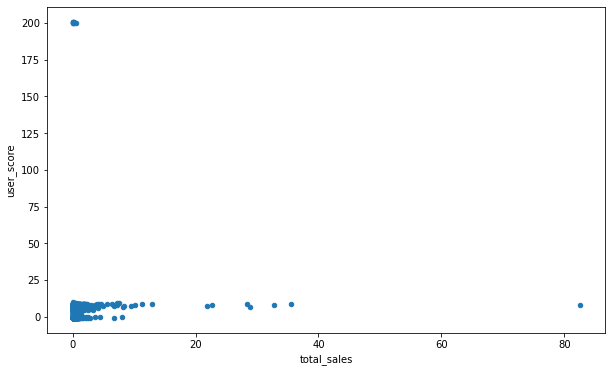

In [171]:
# Creado diagrama de disperción para el total de ventas y la columna "user_score"
new_df[new_df['platform'] == "Wii"].plot.scatter(x='total_sales',y="user_score",figsize=(10,6))

Analizando la gráfica, podemos observar que hay calificaciones que estan alrededor de `200`, esto pudó haber sido un error al momento de hacer la extracción de información de la página web, por tal motivo, procederemos a analizar estos valores.

In [170]:
# Analizando "user_score" igual a "200"
new_df[new_df['user_score'] == 200].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 766 to 16565
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             17 non-null     object 
 1   platform         17 non-null     object 
 2   year_of_release  17 non-null     float64
 3   genre            17 non-null     object 
 4   na_sales         17 non-null     float64
 5   eu_sales         17 non-null     float64
 6   jp_sales         17 non-null     float64
 7   other_sales      17 non-null     float64
 8   critic_score     17 non-null     float64
 9   user_score       17 non-null     float64
 10  classification   17 non-null     object 
 11  total_sales      17 non-null     float64
dtypes: float64(8), object(4)
memory usage: 1.7+ KB


Debido a que son muy pocos los registros con esta condición, procederemos a excluirlos del análisis presentado hasta ahorita, por tal motivo, será presentado nuevamente el gráfico de disperción excluyendo estos valores.

<AxesSubplot:xlabel='total_sales', ylabel='user_score'>

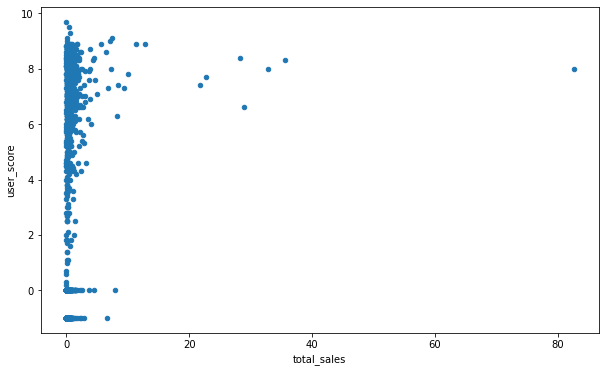

In [175]:
# Creado diagrama de disperción para el total de ventas y la columna "user_score"
new_df[(new_df['platform'] == "Wii") & (new_df['user_score'] < 200.0)].plot.scatter(x='total_sales',y="user_score",figsize=(10,6))

Podemos observar un comportamiento similar al de la columna `critic_score`, concluyendo de forma general que hay una estrecha relación entre los puntajes otorgados por los usuarios y las ventas totales de los títulos.

Todo esto debe estar sustentado de manera formal, por tal razón, procederemos a calcular las correlaciones de los datos en el `df` poniendo especial antención en las ventas totales y las criticas.

In [176]:
# Calculo de correlaciones
new_df[new_df['platform'] == "Wii"].corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.085980,-0.064829,-0.052699,-0.082028,-0.159684,-0.005845,-0.077320
na_sales,-0.085980,1.000000,0.971791,0.769742,0.988304,0.191633,0.023899,0.992603
eu_sales,-0.064829,0.971791,1.000000,0.775997,0.992602,0.172700,0.028215,0.989542
jp_sales,-0.052699,0.769742,0.775997,1.000000,0.769347,0.153180,0.037659,0.813778
other_sales,-0.082028,0.988304,0.992602,0.769347,1.000000,0.174702,0.025153,0.995140
critic_score,-0.159684,0.191633,0.172700,0.153180,0.174702,1.000000,0.117648,0.184688
user_score,-0.005845,0.023899,0.028215,0.037659,0.025153,0.117648,1.000000,0.027443
total_sales,-0.077320,0.992603,0.989542,0.813778,0.995140,0.184688,0.027443,1.000000


Podemos resaltar algo interesante de este resultado, si bien aparentemente no hay una fuerte correlación entre las ventas generadas y las críticas de los profesionales y usuarios, en las gráficas anteriores podemos observar que si es de esa forma. De igual forma podemos resaltar también que si bien el videjuego puede estar bien calificado por profesionales, no es aplicable de la misma manera para los usuarios pues tiene que ver mucho con la experiencia y espectativa de los mismos títulos.

A modo de ejemplo, procederemos a hacer una comparación de las ventas de los videojuegos en otras plataformas.

In [177]:
new_df.pivot_table(index='name',values='total_sales',columns='platform',aggfunc=sum).head(20)

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
name,,,,,,,,,
Beyblade Burst,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fire Emblem Fates,1.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Frozen: Olaf's Quest,0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Haikyu!! Cross Team Match!,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tales of Xillia 2,NaN,NaN,0.84,NaN,NaN,NaN,NaN,NaN,NaN
.hack: Sekai no Mukou ni + Versus,NaN,NaN,0.03,NaN,NaN,NaN,NaN,NaN,NaN
007: Quantum of Solace,NaN,0.02,1.15,NaN,NaN,0.65,NaN,1.48,NaN
10 Minute Solution,NaN,NaN,NaN,NaN,NaN,0.08,NaN,NaN,NaN
101-in-1 Party Megamix Wii,NaN,NaN,NaN,NaN,NaN,0.22,NaN,NaN,NaN


De forma general, podemos observar en la mayoría de títulos, que son exclusivos para una plataforma, sin embargo hay títulos que estan para 2 o incluso 3 plataformas, tal sería el caso de `007: Quantum of Solace` dispoinble para `PC`, `PS3`, `Wii` y `Xbox 360` que presentan ingresos muy variados uno de otro.

Por último analizaremos si hay alguna relación entre las ventas totales y el genero de los diferentes títulos.

## Analizando la relación de las ventas con los generos de los títulos

In [178]:
# Contabilizando los ingresos generados de los videojuegos en contraste con su genero
df_auxiliar = new_df.pivot_table(index='genre',values='total_sales',aggfunc=['sum','count'])
df_auxiliar.columns = ['total_sales_sum','total_sales_count']
df_auxiliar.sort_values(by='total_sales_sum', ascending=False)


,total_sales_sum,total_sales_count
genre,,
Action,911.82,1732
Shooter,703.09,671
Sports,667.31,876
Misc,399.94,687
Role-Playing,344.83,575
Racing,246.63,405
Platform,195.66,201
Fighting,142.63,248
Simulation,141.91,317


De acuerdo con la tabla, podemos observar que hay generos con ventas muy superiores a los restantes de los cuales se destacan `Action` y `Shooter`, además, también esta estrechamente relacionado con la cantidad de títulos con estos generos pues también son de los géneros con más títulos.

No podriamos generalizar una relación directa entre los ingresos generados y el género del videojuego pues esto va de la mano también con la cantidad de títulos catalogados en estas categorías.


# Perfil de usuario para cada región

Esta sección pretende presentar el comportamiento de las ventas en las distintas regiones de acuerdo a las `plataformas`, `generos` y `clasificación`. Comenzaremos con el análisis para las plataformas considerando las 5 plataformas principales.

## Ingresos por región en contraste con la plataforma presentada

In [179]:
# Presentando el orden de importancia de las plataformas 
new_df.pivot_table(index='platform',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)


,total_sales
platform,
X360,966.54
PS3,935.11
Wii,903.21
PS4,314.14
PC,258.86
3DS,258.53
XOne,159.32
WiiU,82.19
PSV,53.81


In [182]:
# Construyendo la tabla con las variaciones de cuotas por región
plataformas = ['X360','PS3','Wii','PS4','PC']
new_df[new_df['platform'].isin(plataformas)].pivot_table(index='platform',
                                                values=['na_sales','eu_sales','jp_sales'],
                                                aggfunc='sum').sort_values(by='na_sales',ascending=False)

,eu_sales,jp_sales,na_sales
platform,,,
X360,269.83,12.33,599.04
Wii,261.48,69.05,493.92
PS3,328.97,79.52,391.53
PS4,141.09,15.96,108.74
PC,142.16,0.17,94.23


De acuerdo con la tabla podemos observar que las variaciones de ingresos son considerablemente menores para la región de `Japón`.

## Ingresos por región en contraste con el género del título

In [181]:
# Presentando el orden de importancia de los géneros
new_df.pivot_table(index='genre',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)


,total_sales
genre,
Action,911.82
Shooter,703.09
Sports,667.31
Misc,399.94
Role-Playing,344.83
Racing,246.63
Platform,195.66
Fighting,142.63
Simulation,141.91


In [183]:
# Construyendo la tabla con las variaciones de cuotas por género
new_df[(new_df['genre'] == 'Action') | 
       (new_df['genre'] == 'Shooter') | 
       (new_df['genre'] == 'Sports') |
       (new_df['genre'] == 'Misc') |
       (new_df['genre'] == 'Role-Playing')].pivot_table(index='genre',
                                                  values=['na_sales','eu_sales','jp_sales'],
                                                  aggfunc='sum').sort_values(by='na_sales',ascending=False)

,eu_sales,jp_sales,na_sales
genre,,,
Action,307.93,73.03,427.45
Shooter,237.29,17.61,367.38
Sports,225.89,31.18,339.90
Misc,113.50,27.04,222.86
Role-Playing,96.06,79.27,139.70


Para el caso de los géneros podemos observar un comportamiento similar en el que las ventas para la región de `Japón` son considerablemente menores para los distintos `géneros` exceptuando `Role-Playing`.

## Ingresos por región en contraste con la clasficación del título

In [184]:
# Presentando el orden de importancia de la clasificación
new_df.pivot_table(index='classification',values='total_sales',aggfunc='sum').sort_values(by='total_sales',ascending=False)


,total_sales
classification,
E,1247.27
M,1165.47
T,778.14
E10+,489.92
-,199.52
K-A,50.59
EC,0.75
RP,0.05


In [185]:
# Construyendo la tabla con las variaciones de cuotas por región
new_df.pivot_table(index='classification',values=['na_sales','eu_sales','jp_sales'],
                                                aggfunc='sum').sort_values(by='na_sales',ascending=False)

,eu_sales,jp_sales,na_sales
classification,,,
E,404.58,117.34,605.13
M,404.28,47.47,577.26
T,246.45,63.71,386.88
E10+,156.14,21.47,261.73
-,67.54,52.78,62.28
K-A,15.75,10.09,20.27
EC,0.00,0.00,0.71
RP,0.04,0.00,0.00


Para el caso de la relación de ventas de los títulos dependiendo de la `clasificación` otorgada, podemos ver que no hay relevancia o tendencia por una en específico pues los ingresos son acordes a la región en comparación con los puntos anteriores.

Por último para dar sustento a todo lo anterior procederemos con las pruebas de hipótesis

# Pruebas de hipótesis

## Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

Para esta prueba de hipótesis debemos establecer la hipótesis nula y alternativa que serán las siguientes:
- H0: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.
- Ha: Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

Para las pruebas de hipótesis es importante identificar cuál es la adecuada. Tenemos 4 opciones para poder trabajar y debemos conocer que es lo que esta pasando con nuestras pruebas y saber con que datos contamos:
- `Hipótesis con dos colas`: Requerímos de un valor específico de comparación con la media de la muestra.
- `Hipótesis con una cola`: Requerimos un valor específico de comparación con la media de la muestar, en este caso nuestro `p value` se dividirá entre 2 para considerar ambas posiciones.
- `Hipótesis sobre la igualdad de las medias de dos poblaciones`: Requerimos de dos muestras y si se sabe conoce la varianza de ambas muestras y estas son iguales puede ajustarse el parámetro `equal_var = True`, en caso contrario se coloca en `False`.
- `Hipótesis sobre la igualdad de las medias de muestras emparejadas`:  Requereimos de dos muestras con la característica de que estas provienen del mismo set de datos con una diferencia temporal.

Puesto que compararemos dos poblaciones diferentes haremos uso de la `Hipótesis sobre la igualdad de las medias de dos poblaciones` por lo siguiente:
- Vamos a compara dos muestras que aunque provienden del mismo set de datos, estas son independientes una de otra puesto que vamos a comparar las calificaciones promedio para los títulos de la plataforma `Xbox One` y `PC`.
- Si bien estas muestras varian conforme el tiempo la intención es conocer la calificación de usuario promedio entre dos conjuntos, más no la calificación promedio de un conjunto a lo largo del tiempo.
- No contamos con un parámetro en específico con el que queramos trabajar para compara con la media de la muestra.

Ajustaremos el valor α = 5% que es un valor convencional de significación estadística y ejecutaremos la prueba de `hipótesis sobre la igualdad de medias de dos poblaciones`.

Para poder ejecutar la prueba de hipótesis, es importante primero determinar si las muestras tienen varianzas iguales o similares mayormente, para esto, pondremos a prueba dichas muestras usando el algoritmo de `Levene` que se encarga de probar que todas las entradas de la hipótesis nula tienen varianzas iguales.

In [188]:
# Procederemos con la lectura nuevamente del archivo
new_df = pd.read_csv("datasets/games_v2.csv")
new_df.drop(['Unnamed: 0','index'],axis=1,inplace=True)
new_df = new_df.drop(new_df[new_df['genre'] == 0].index)
new_df.loc[new_df['user_score'] == 'tbd'] = -1
new_df = new_df.astype({'user_score':'float64'})
new_df = new_df[new_df['user_score'] > 0.0]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9948 entries, 0 to 16565
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             9948 non-null   object 
 1   platform         9948 non-null   object 
 2   year_of_release  9948 non-null   float64
 3   genre            9948 non-null   object 
 4   na_sales         9948 non-null   float64
 5   eu_sales         9948 non-null   float64
 6   jp_sales         9948 non-null   float64
 7   other_sales      9948 non-null   float64
 8   critic_score     9948 non-null   float64
 9   user_score       9948 non-null   float64
 10  classification   9948 non-null   object 
dtypes: float64(7), object(4)
memory usage: 932.6+ KB


In [189]:
# Ejecutando la prueba de "Levene"
alpha = 0.05
stat,p = levene(new_df[new_df['platform'] == 'XOne']['user_score'],
                new_df[new_df['platform'] == 'PC']['user_score'])
print("P value:", p)
if p < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

P value: 0.11982498265271496
No rechazamos la hipótesis nula


De acuerdo con `p value` de la `prueba de levene` nos indica que `no se rechaza la hipótesis nula`, por ende `equal_var = True`.

In [190]:
# Ejecutando prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(new_df[new_df['platform'] == 'XOne']['user_score'],
                       new_df[new_df['platform'] == 'PS']['user_score'],
                       equal_var = True)

print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  0.0005475023295852477
Rechazamos la hipótesis nula


De acuerdo con el resultado, tenemos suficiente evidencia como para rechazar la hipótesis nula, por ende, podemos afirmar con más del `99%` de seguridad que las calificaciones promedio de los usuarios para la plataforma `Xbox One` y `PC` son diferentes.

## Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

Al compara nuevamente dos set de datos distintos, se tienen las mismas características que la prueba anterior, por tal motivo, haremos uso de `hipótesis sobre la igualdad de medias de dos poblaciones` donde:
- H0: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.
- Ha: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [191]:
# Ejecutando la prueba de "Levene"
alpha = 0.05
stat,p = levene(new_df[new_df['genre'] == 'Action']['user_score'],
                new_df[new_df['genre'] == 'Sports']['user_score'])
print("P value:", p)
if p < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

P value: 8.308551368354028e-28
Rechazamos la hipótesis nula


De acuerdo el resultado de `p-value` rechazamos la hipótesis nula de la prueba de `Levene`, por lo que el parámetro `equal_var = False`.

In [192]:
# Ejecutando prueba de hipótesis
alpha = 0.05
results = st.ttest_ind(new_df[new_df['genre'] == 'Action']['user_score'],
                       new_df[new_df['genre'] == 'Sports']['user_score'],
                       equal_var = False)

print('p-value: ', results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value:  1.3690333833947155e-19
Rechazamos la hipótesis nula


Este resultado nos indica que tenemos una probabilidad menor al `5%` de encontrarnos con una muestra similar en ambos conjuntos por lo que la hipótesis nula es rechazada pues tenemos la evidencia suficiente como para decir que la calificación promedio de los usuarios para los géneros de `Acción` y `Deportes` son diferentes.

# Conclusiones

Para poder generar campañas exitosas en un futuro, se deben tomar varios aspectos a consideración y son los siguientes:

- Dichas campañas deben ser ajustadas a plataformas que se encuentren vigentes en el presente, esto es porque a medida que nuevas plataformas entran al mercado, los modelos anteriores van quedando resagados provocando eventualmente su salida del mercado con el paso de los años.
- El éxito de las campañas depende mucho de la región para la que vayan dirigidos puesto que es evidente a lo largo de todo este proyecto que ciertas regiones tienen preferencia por ciertas plataformas, así también hay preferencia por géneros de los títulos.
- La clasificación de los videojuegos parece ser un aspecto que no es tan relevante para una campaña exitosa.
- Un campaña exitosa por lo general proviene de una anterior con las mismas características que ya fue exitosa, es decir, versiones del mismo título, para las distintas plataformas en conjunto con los avances tecnológicos en la industria del entretenimiento a través de videojuegos podría potenciar el éxito.

Respecto a las preferencias por región podemos destacar que:
- Al tratarse de la región de Norteamerica o Europa, se tiene preferencia notablemente por títulos para la consola `PS3`, sin embargo para la región de `Japón`, es evidente que la plataforma preferida es `Nintendo DS` actualmente.
- Respecto al género, Norteamerica y Europa tienen preferencia por aquellos títulos de `Acción` mientras que Japón prefiere el genero de `Role-Playing`.